In [7]:
from datetime import datetime, timedelta
from pathlib import Path

import itertools
import matplotlib
from vivarium import Artifact, InteractiveContext
import ipywidgets
import pandas as pd, numpy as np
import seaborn as sns
pd.set_option('display.max_rows', 8)
import os
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'/ihme/homes/alibow/notebooks/vivarium_research_ciff_sam/model_validation/lbwsg'

In [3]:
os.listdir()

['lbwsg_log_mean_rr_countour_by_age_and_sex.pdf',
 'demography.py',
 'lbwsg_plots.py',
 'plot_lbwsg_rrs_by_exposure.ipynb',
 'lbwsg_category_data.csv',
 'lbwsg_log_rr_countour_by_age_and_sex_for_draw_602.pdf',
 'lbwsg_rr.py',
 '.ipynb_checkpoints',
 'lbwsg.py',
 '2021_06_25a_lbwsg_rr_interpolation_by_age_sex.ipynb',
 'lbwsg_log_rr_countour_age_2_sex_2_draw_602.pdf',
 '2022_01_11a_lbwsg_relative_risk_verification.ipynb',
 'lbwsg_data_5.2.0_with_interp_rrs.pickle.zip']

In [4]:
data = pd.read_pickle('lbwsg_data_5.2.0_with_interp_rrs.pickle.zip')
data['abs_diff'] = (data.sim_relative_risk - data.interp_relative_risk)
data['pct_diff'] = data.abs_diff / data.interp_relative_risk * 100
data

,simulant_id,age,sex,lbwsg_category,birthweight,sim_relative_risk,gestational_age,age_group,time_point,age_group_id,sex_id,interp_relative_risk,interp_minus_sim,abs_diff,pct_diff
0,0,0.044994,Male,cat40,2580.395737,4.244653,36.164988,late_neonatal,initialization,3,1,4.244653,0.0,0.0,0.0
1,1,0.046464,Male,cat52,3448.290620,1.019543,38.995680,late_neonatal,initialization,3,1,1.019543,0.0,0.0,0.0
2,2,0.052629,Female,cat42,2926.178834,2.288050,37.375198,late_neonatal,initialization,3,2,2.288050,0.0,0.0,0.0
3,3,0.075327,Female,cat54,3681.270909,1.000000,39.985003,late_neonatal,initialization,3,2,1.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201781,201093,0.001250,Male,cat52,3290.490054,1.000000,39.547385,early_neonatal,28_days,2,1,1.000000,0.0,0.0,0.0
201782,201094,0.000131,Female,cat55,3726.968971,1.000000,40.190626,early_neonatal,28_days,2,2,1.000000,0.0,0.0,0.0
201783,201095,0.000854,Female,cat52,3270.917903,1.065181,38.170893,early_neonatal,28_days,2,2,1.065181,0.0,0.0,0.0
201784,201096,0.000397,Female,cat55,3594.525425,1.000000,40.189295,early_neonatal,28_days,2,2,1.000000,0.0,0.0,0.0


count    17980.000000
mean         0.968608
std         10.221013
min       -163.185574
25%         -0.323877
50%          0.080600
75%          0.698766
max        138.852523
Name: abs_diff, dtype: float64

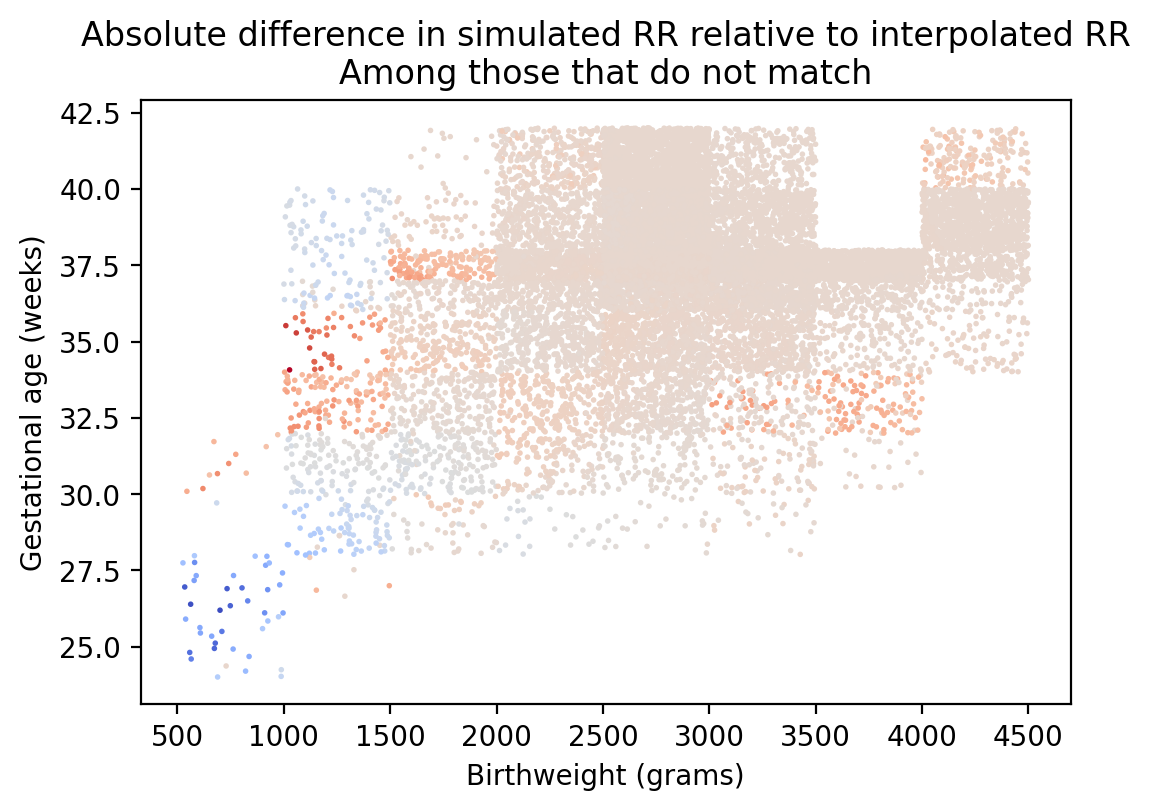

In [11]:
p = data.loc[(data.interp_minus_sim!=0)
                    #&(data.sex=='Female')
            ]
plt.figure(dpi=200)
plt.scatter(p.birthweight, p.gestational_age, s=1, c=p.abs_diff, cmap=plt.cm.coolwarm)
plt.xlabel('Birthweight (grams)')
plt.ylabel('Gestational age (weeks)')
plt.title('Absolute difference in simulated RR relative to interpolated RR\nAmong those that do not match')
p.abs_diff.describe()

count    17980.000000
mean        29.475965
std        172.302659
min        -72.120345
25%        -15.142141
50%          2.290353
75%         27.742562
max       3710.491336
Name: pct_diff, dtype: float64

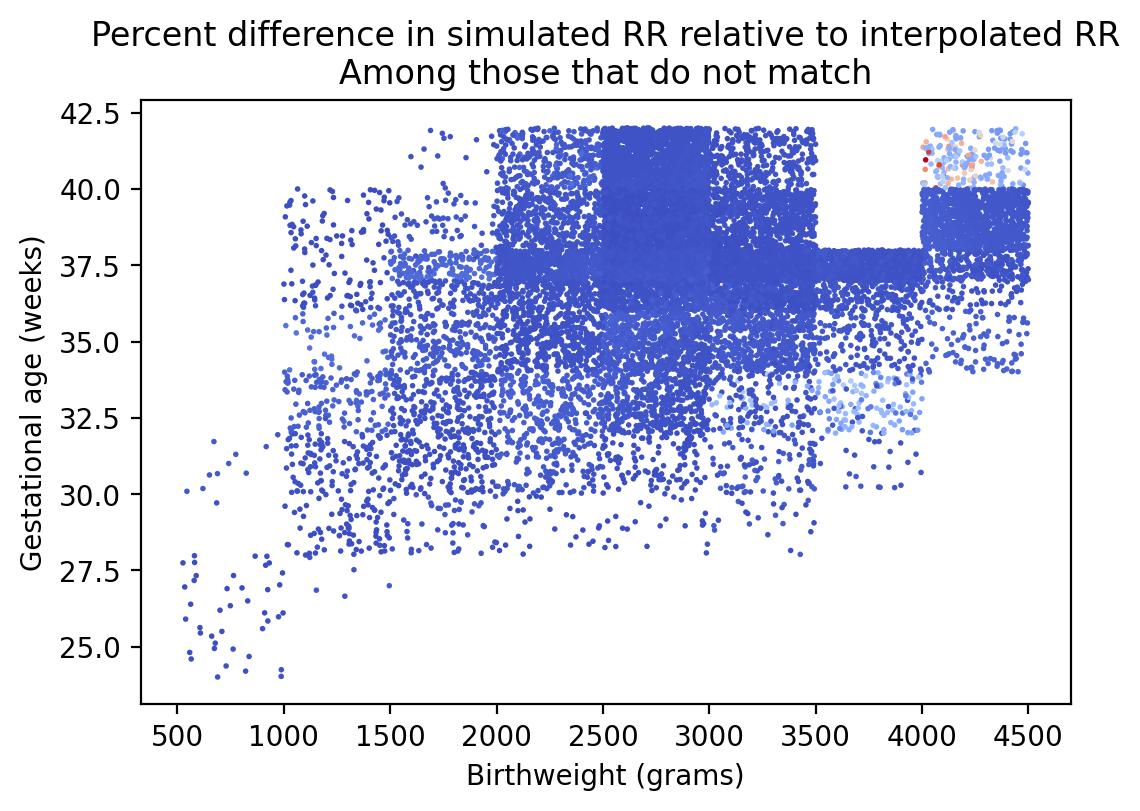

In [12]:
p = data.loc[(data.interp_minus_sim!=0)
            #&(data.sex=='Female')
            #&(data.birthweight<3500)
            ]
plt.figure(dpi=200)
plt.scatter(p.birthweight, p.gestational_age, s=1, c=p.pct_diff, cmap=plt.cm.coolwarm)
plt.xlabel('Birthweight (grams)')
plt.ylabel('Gestational age (weeks)')
plt.title('Percent difference in simulated RR relative to interpolated RR\nAmong those that do not match')
p.pct_diff.describe()

In [13]:
art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf',
               filter_terms=['year_start == 2019', f'age_end <= 5'])
art_exposure = art.load(f'risk_factor.low_birth_weight_and_short_gestation.exposure')['draw_0'].reset_index()
art_cats = art.load(f'risk_factor.low_birth_weight_and_short_gestation.categories')
art_exposure['bw_start'] = np.nan
art_exposure['bw_end'] = np.nan
art_exposure['ga_start'] = np.nan
art_exposure['ga_end'] = np.nan
for i in art_exposure.index:
    art_exposure['bw_start'][i] = art_cats[art_exposure.parameter[i]].split('wks, [')[1].split(',')[0]
    art_exposure['bw_end'][i] = art_cats[art_exposure.parameter[i]].split('wks, [')[1].split(', ')[1].split(')')[0]
    art_exposure['ga_start'][i] = art_cats[art_exposure.parameter[i]].split('- [')[1].split(', ')[0]
    art_exposure['ga_end'][i] = art_cats[art_exposure.parameter[i]].split('- [')[1].split(') wks')[0].split(', ')[1]
    
art_exposure['bw_mid'] = (art_exposure.bw_end - art_exposure.bw_start)/2 + art_exposure.bw_start
art_exposure['ga_mid'] = (art_exposure.ga_end - art_exposure.ga_start)/2 + art_exposure.ga_start
art_exposure['age_group'] = np.where(art_exposure.age_end==0,'birth',
                                    np.where(art_exposure.age_start==0,'early_neonatal',
                                            np.where(art_exposure.age_end < 0.08, 'late_neonatal', 'other')))
art_exposure

<ipython-input-13-73bc7bed4ca5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  art_exposure['bw_start'][i] = art_cats[art_exposure.parameter[i]].split('wks, [')[1].split(',')[0]
<ipython-input-13-73bc7bed4ca5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  art_exposure['bw_end'][i] = art_cats[art_exposure.parameter[i]].split('wks, [')[1].split(', ')[1].split(')')[0]
<ipython-input-13-73bc7bed4ca5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

,sex,age_start,age_end,year_start,year_end,parameter,draw_0,bw_start,bw_end,ga_start,ga_end,bw_mid,ga_mid,age_group
0,Female,-1.000000,0.000000,2019,2020,cat10,0.001853,500.0,1000.0,24.0,26.0,750.0,25.0,birth
1,Female,-1.000000,0.000000,2019,2020,cat106,0.000644,1000.0,1500.0,36.0,37.0,1250.0,36.5,birth
2,Female,-1.000000,0.000000,2019,2020,cat11,0.001160,500.0,1000.0,26.0,28.0,750.0,27.0,birth
3,Female,-1.000000,0.000000,2019,2020,cat116,0.001423,1000.0,1500.0,38.0,40.0,1250.0,39.0,birth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,Male,0.019178,0.076712,2019,2020,cat89,0.001273,3000.0,3500.0,30.0,32.0,3250.0,31.0,late_neonatal
345,Male,0.019178,0.076712,2019,2020,cat90,0.000562,3500.0,4000.0,30.0,32.0,3750.0,31.0,late_neonatal
346,Male,0.019178,0.076712,2019,2020,cat95,0.003673,3000.0,3500.0,32.0,34.0,3250.0,33.0,late_neonatal
347,Male,0.019178,0.076712,2019,2020,cat96,0.002109,3500.0,4000.0,32.0,34.0,3750.0,33.0,late_neonatal


In [15]:
prep = data.merge(art_exposure[['parameter','ga_mid','bw_mid']].rename(columns={'parameter':'lbwsg_category'}), 
                  on='lbwsg_category')
prep

,simulant_id,age,sex,lbwsg_category,birthweight,sim_relative_risk,gestational_age,age_group,time_point,age_group_id,sex_id,interp_relative_risk,interp_minus_sim,abs_diff,pct_diff,ga_mid,bw_mid
0,0,0.044994,Male,cat40,2580.395737,4.244653,36.164988,late_neonatal,initialization,3,1,4.244653,0.0,0.0,0.0,36.5,2750.0
1,0,0.044994,Male,cat40,2580.395737,4.244653,36.164988,late_neonatal,initialization,3,1,4.244653,0.0,0.0,0.0,36.5,2750.0
2,0,0.044994,Male,cat40,2580.395737,4.244653,36.164988,late_neonatal,initialization,3,1,4.244653,0.0,0.0,0.0,36.5,2750.0
3,0,0.044994,Male,cat40,2580.395737,4.244653,36.164988,late_neonatal,initialization,3,1,4.244653,0.0,0.0,0.0,36.5,2750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210706,199051,0.002237,Male,cat2,299.029890,918.084874,1.564910,early_neonatal,28_days,2,1,918.084874,0.0,0.0,0.0,12.0,250.0
1210707,199051,0.002237,Male,cat2,299.029890,918.084874,1.564910,early_neonatal,28_days,2,1,918.084874,0.0,0.0,0.0,12.0,250.0
1210708,199051,0.002237,Male,cat2,299.029890,918.084874,1.564910,early_neonatal,28_days,2,1,918.084874,0.0,0.0,0.0,12.0,250.0
1210709,199051,0.002237,Male,cat2,299.029890,918.084874,1.564910,early_neonatal,28_days,2,1,918.084874,0.0,0.0,0.0,12.0,250.0


In [16]:
p = prep.loc[prep.abs_diff!=0]
p = p.groupby(['lbwsg_category','ga_mid','bw_mid']).describe(percentiles=[0.025,0.975]).reset_index()
abs_prep = p.pivot_table(index='ga_mid', columns='bw_mid', values=('abs_diff')).sort_index(ascending=False)
abs_prep

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


2.5%                                                      \
bw_mid      750.0         1250.0        1750.0        2250.0    2750.0   
ga_mid                                                                   
41.0           NaN           NaN -4.069962e-02 -1.299307e+00 -0.368165   
39.0           NaN -3.226684e+01  1.228833e+00 -1.551048e-01 -2.156728   
37.5           NaN -3.459733e+01  3.552714e-15 -8.881784e-16 -0.762639   
36.5           NaN -4.004703e+01 -2.659356e+00 -9.005043e-01 -1.245637   
...            ...           ...           ...           ...       ...   
31.0     25.677525 -2.682506e+01 -1.990069e+01 -3.518494e+00 -5.878054   
29.0    -30.656816 -6.811458e+01 -1.141826e+01 -1.887338e+01 -9.920991   
27.0   -163.185574  1.421085e-14           NaN           NaN       NaN   
25.0   -144.464692           NaN           NaN           NaN       NaN   

                                            50%             ...       min  \
bw_mid    3250.0    3750.0    4250.0     750.0      1250.0  ...    3750.0   
ga_mid                                                      ...             
41.0   -0.527077       NaN  6.108114        NaN        NaN  ...       NaN   
39.0   -0.674145       NaN  0.158315        NaN -25.355991  ...       NaN   
37.5   -0.676204 -0.412704 -0.341416        NaN -30.742558  ... -0.454053   
36.5   -0.876627 -0.540283 -0.310391        NaN -26.559170  ... -0.573586   
...          ...       ...       ...        ...        ...  ...       ...   
31.0   -2.150149 -0.679562       NaN  43.441039 -12.609877  ... -0.679562   
29.0   -4.770204       NaN       NaN -30.656816 -37.341234  ...       NaN   
27.0         NaN       NaN       NaN -99.272020  15.155551  ...       NaN   
25.0         NaN       NaN       NaN -90.969931        NaN  ...       NaN   

                        std                                            \
bw_mid    4250.0     750.0      1250.0     1750.0    2250.0    2750.0   
ga_mid                                                                  
41.0    5.738829        NaN        NaN   0.498543  3.573646  0.203943   
39.0    0.125547        NaN   3.500113   0.757665  0.592994  0.782346   
37.5   -0.392241        NaN   3.518267  11.893139  0.979026  0.597384   
36.5   -0.322379        NaN  15.958998   1.382798  0.229610  1.029694   
...          ...        ...        ...        ...       ...       ...   
31.0         NaN  17.991653   5.122709   4.115814  5.014751  0.940919   
29.0         NaN   0.000000  15.430272   8.018880  3.002819  1.826483   
27.0         NaN  30.804408  19.514119        NaN       NaN       NaN   
25.0         NaN  40.104175        NaN        NaN       NaN       NaN   

                                      
bw_mid    3250.0    3750.0    4250.0  
ga_mid                                
41.0    0.180252       NaN  7.403426  
39.0    0.214248       NaN  0.213474  
37.5    0.271251  0.316809  0.381601  
36.5    0.767504  0.368838  0.407515  
...          ...       ...       ...  
31.0    3.564967  0.975377       NaN  
29.0    4.770632       NaN       NaN  
27.0         NaN       NaN       NaN  
25.0         NaN       NaN       NaN  

[10 rows x 64 columns]

Text(0.5, 1.0, 'Absolute difference: mean value')

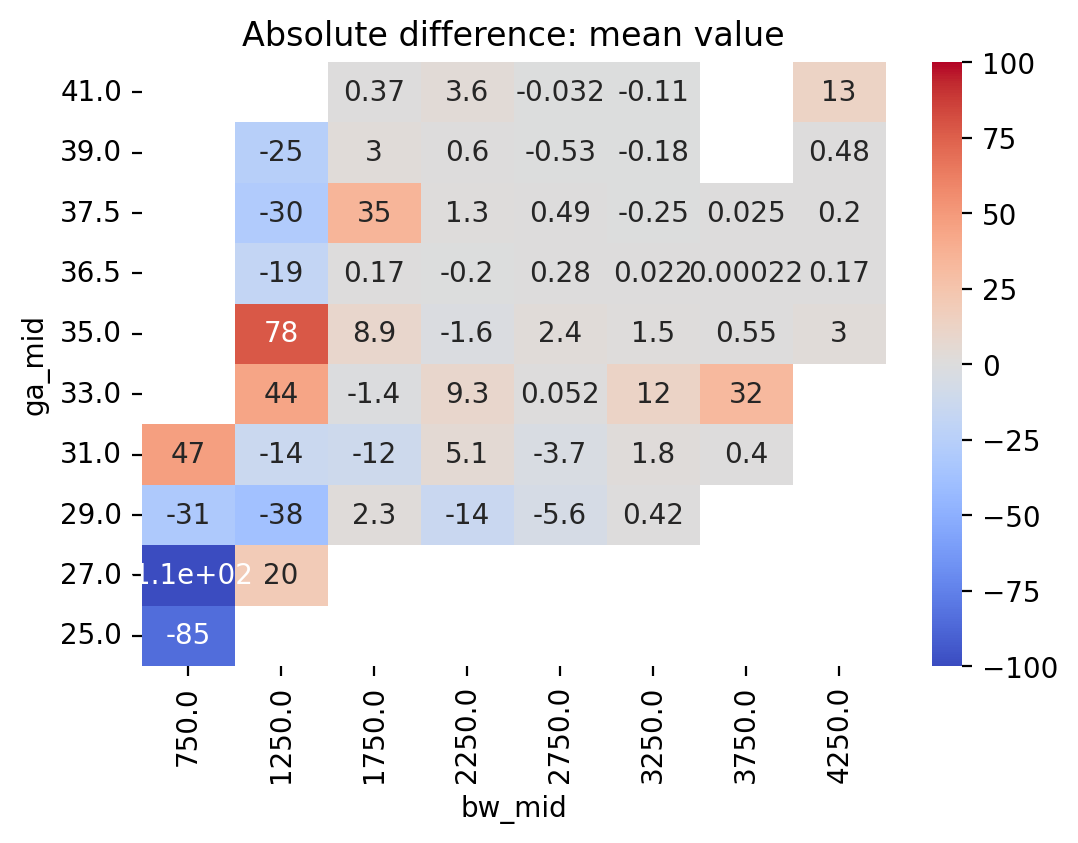

In [17]:
plt.figure(dpi=200)
sns.heatmap(abs_prep['mean'], annot=True,cmap="coolwarm",vmin=-100,vmax=100)
plt.title('Absolute difference: mean value')

Text(0.5, 1.0, 'Absolute difference: standard deviation')

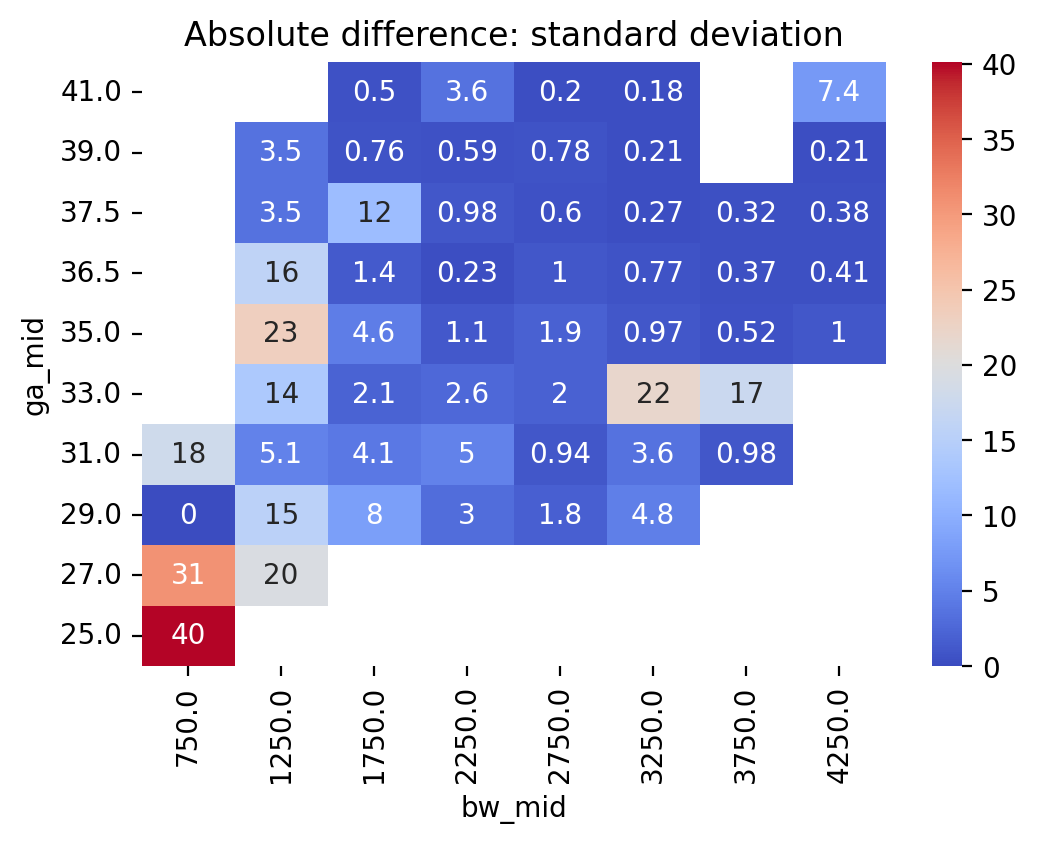

In [18]:
plt.figure(dpi=200)
sns.heatmap(abs_prep['std'], annot=True,cmap="coolwarm")
plt.title('Absolute difference: standard deviation')

In [19]:
p = prep.loc[prep.abs_diff!=0]
p = p.groupby(['lbwsg_category','ga_mid','bw_mid']).describe(percentiles=[0.025,0.975]).reset_index()
pct_prep = p.pivot_table(index='ga_mid', columns='bw_mid', values=('pct_diff')).sort_index(ascending=False)
pct_prep

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


2.5%                                                       \
bw_mid     750.0         1250.0        1750.0        2250.0     2750.0   
ga_mid                                                                   
41.0          NaN           NaN -3.028964e-01 -9.967299e+00  -9.483435   
39.0          NaN -6.441312e+01  6.613996e+00 -1.298292e+00 -52.703667   
37.5          NaN -6.425006e+01  1.531619e-14 -1.706679e-14 -21.297353   
36.5          NaN -6.695503e+01 -9.418071e+00 -1.430696e+01 -30.040201   
...           ...           ...           ...           ...        ...   
31.0    18.595760 -3.664690e+01 -5.011686e+01 -1.948034e+01 -49.587777   
29.0   -19.147217 -5.532502e+01 -1.824273e+01 -7.212035e+01 -63.827121   
27.0   -58.995034  1.144407e-14           NaN           NaN        NaN   
25.0   -36.155587           NaN           NaN           NaN        NaN   

                                                50%             ...  \
bw_mid     3250.0     3750.0      4250.0     750.0      1250.0  ...   
ga_mid                                                          ...   
41.0   -28.616741        NaN  610.811427        NaN        NaN  ...   
39.0   -40.268005        NaN   15.831512        NaN -57.354635  ...   
37.5   -33.630998 -26.219418  -23.028715        NaN -61.997979  ...   
36.5   -31.932885 -23.560180  -16.577344        NaN -51.094522  ...   
...           ...        ...         ...        ...        ...  ...   
31.0   -32.170005 -14.871530         NaN  34.079013 -21.853011  ...   
29.0   -49.831306        NaN         NaN -19.147217 -49.139141  ...   
27.0          NaN        NaN         NaN -50.402423  12.473458  ...   
25.0          NaN        NaN         NaN -27.135324        NaN  ...   

              min                    std                                   \
bw_mid     3750.0      4250.0     750.0      1250.0     1750.0     2250.0   
ga_mid                                                                      
41.0          NaN  573.882932        NaN        NaN   2.377285  50.873823   
39.0          NaN   12.554650        NaN   8.970250   3.662772   7.207273   
37.5   -28.725871  -25.887344        NaN   5.488575  46.645559  18.162797   
36.5   -23.793301  -16.595968        NaN  29.709864   5.412741   3.641391   
...           ...         ...        ...        ...        ...        ...   
31.0   -14.871530         NaN  16.588268   5.154540   9.782424  31.509337   
29.0          NaN         NaN   0.000000  12.395554  20.666511   6.748373   
27.0          NaN         NaN   8.725710  24.356962        NaN        NaN   
25.0          NaN         NaN   9.018561        NaN        NaN        NaN   

                                                     
bw_mid     2750.0     3250.0     3750.0      4250.0  
ga_mid                                               
41.0     7.488351  11.403749        NaN  740.342550  
39.0    23.148165  14.211300        NaN   21.347407  
37.5    20.974362  15.184195  23.756283   31.822978  
36.5    28.762575  33.320279  19.690128   26.311811  
...           ...        ...        ...         ...  
31.0     8.877678  47.382192  18.755385         NaN  
29.0    11.010509  52.904343        NaN         NaN  
27.0          NaN        NaN        NaN         NaN  
25.0          NaN        NaN        NaN         NaN  

[10 rows x 64 columns]

Text(0.5, 1.0, 'Percent difference: mean')

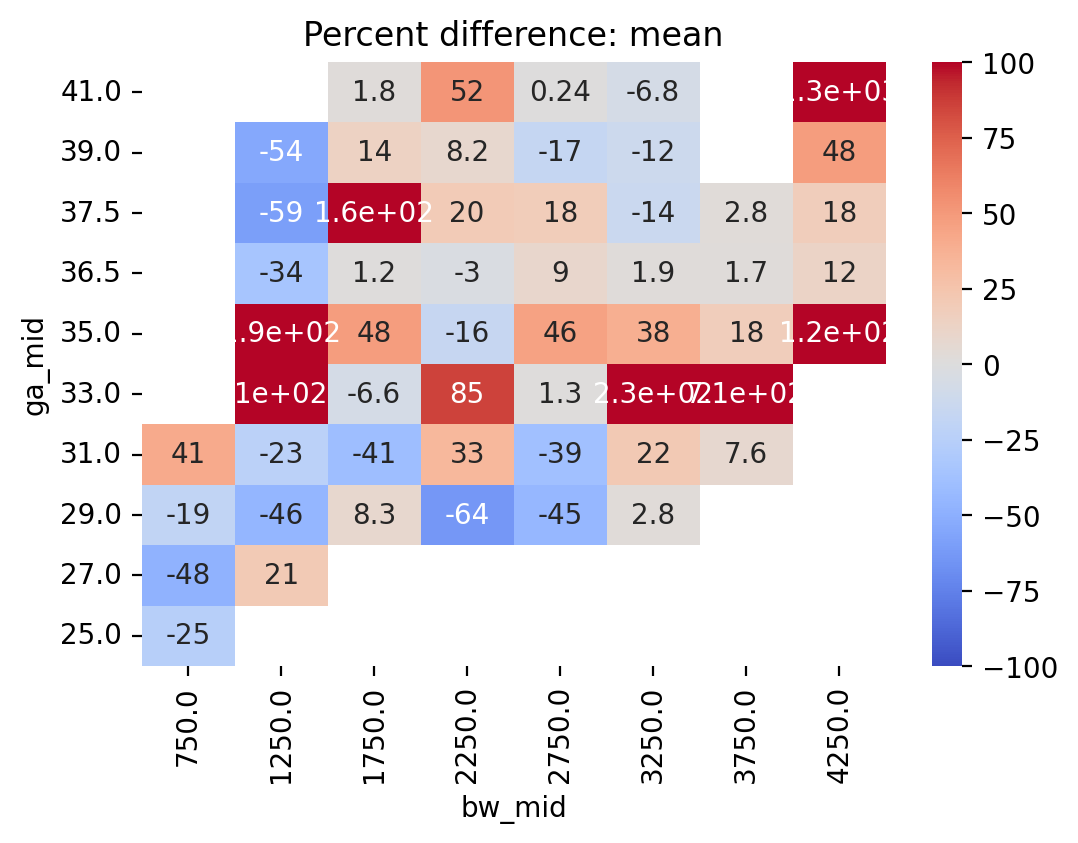

In [20]:
plt.figure(dpi=200)
sns.heatmap(pct_prep['mean'], annot=True,cmap="coolwarm",vmin=-100,vmax=100)
plt.title('Percent difference: mean')

Text(0.5, 1.0, 'Percent difference: standard deviation')

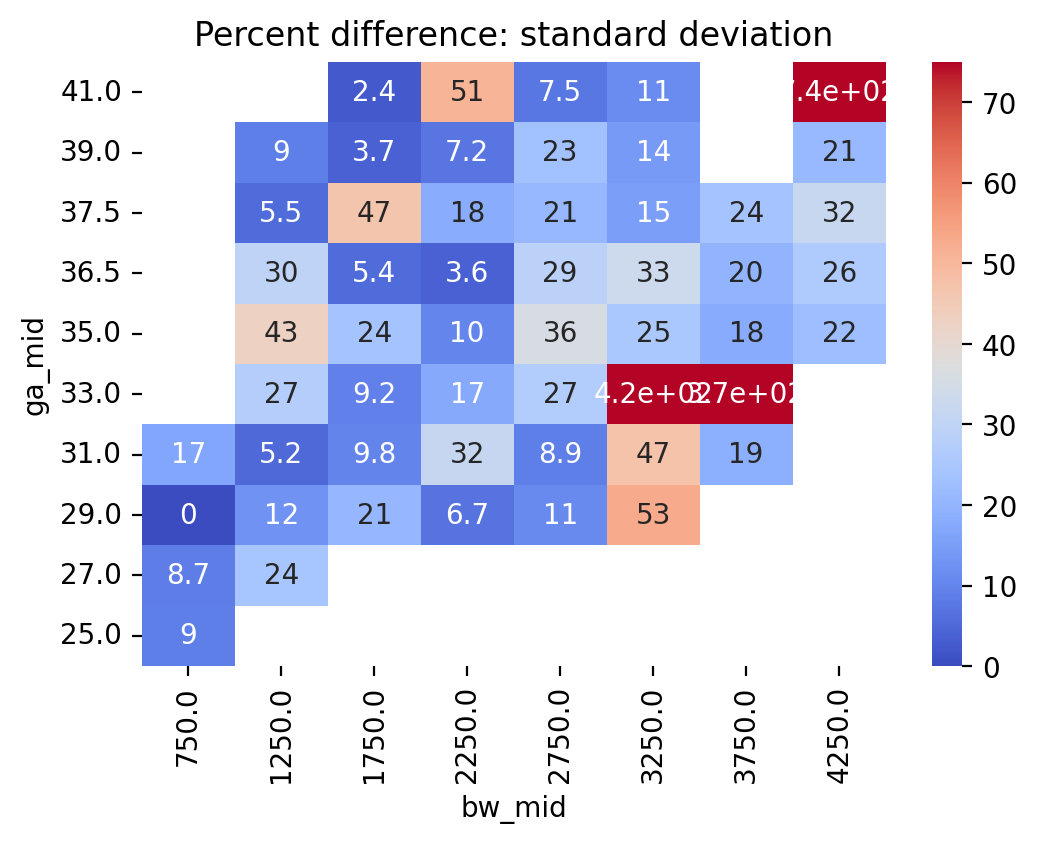

In [21]:
plt.figure(dpi=200)
sns.heatmap(pct_prep['std'], annot=True,cmap="coolwarm",vmin=0,vmax=75)
plt.title('Percent difference: standard deviation')